&copy; 2024, Akshay Suresh 

<center><h3>Deep Learning for Oil Well Detection in Satellite Imagery</h3></center>
<br>

**Objective:** Train a neural network to detect oil wells in satellite images. The algorithm should return a list of coordinates of all possible wells in the image.

### Sections

1. [Exploratory Data Analysis](#eda)
2. [Model Selection](#model-selection) <br>
    i) [Chosen Approach: Few-shot Transfer Learning for Binary Semantic Segmentation Using U-Net](#chosen-model) <br>
    ii) [Model Limitation and Alternate Approaches](#other-approaches)
3. [Data Preparation](#data-prep) <br>
   i) [Train-validation split](#data-split) <br>
   ii) [Data Scaling and Augmentation](#data-aug)
4. [Model Training](#model-training) <br>
    i) [Chosen Loss Function: Dice Loss](#loss-function) <br>
    ii) [Loss Curve](#loss-curve)
5. [Future Work and Additional Insights](#future-work) <br>

---


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scipy.stats import ks_2samp
from torchsummary import summary
from scripts.data_utils import custom_train_val_split
from scripts.unet_model import UNet

### 1. Exploratory Data Analysis (EDA) <a name="eda"></a>

The `data_raw` folder contains all original data supplied for the challenge, which includes 294 .tif images and a .csv file of 1753 labeled oil wells. As a first step, let's inspect how these wells look in .tif images as well as study their frequency of occurrence across images.

The script `parse_tif.py` reads in .tif images one by one and checks for labeled wells contained inside each image. For every input .tif image, `parse_tif.py` outputs two data products.
1. A .png raster plot of the RGB geospatial data with labeled wells marked as light blue scatter points.
2. A .csv file of well locations enclosed within the image grid

In addition to the above outputs, `parse_tif.py` also generates a file `summary.csv` that keeps count of the number of labeled wells found in each image.

In [2]:
%run scripts/parse_tif.py -tif data_raw/images -loc data_raw/well_locations.csv -out eda

2024-02-18 04:17:50 AM - INFO - Processing .tif file 1 out of 294
2024-02-18 04:17:53 AM - INFO - Processing .tif file 11 out of 294
2024-02-18 04:17:55 AM - INFO - Processing .tif file 21 out of 294
2024-02-18 04:17:57 AM - INFO - Processing .tif file 31 out of 294
2024-02-18 04:17:59 AM - INFO - Processing .tif file 41 out of 294
2024-02-18 04:18:01 AM - INFO - Processing .tif file 51 out of 294
2024-02-18 04:18:04 AM - INFO - Processing .tif file 61 out of 294
2024-02-18 04:18:06 AM - INFO - Processing .tif file 71 out of 294
2024-02-18 04:18:08 AM - INFO - Processing .tif file 81 out of 294
2024-02-18 04:18:10 AM - INFO - Processing .tif file 91 out of 294
2024-02-18 04:18:12 AM - INFO - Processing .tif file 101 out of 294
2024-02-18 04:18:15 AM - INFO - Processing .tif file 111 out of 294
2024-02-18 04:18:17 AM - INFO - Processing .tif file 121 out of 294
2024-02-18 04:18:19 AM - INFO - Processing .tif file 131 out of 294
2024-02-18 04:18:21 AM - INFO - Processing .tif file 141 ou

<Figure size 640x480 with 0 Axes>

**How are the labeled oil wells distributed across various images?**

In [3]:
counts_df = pd.read_csv('eda/summary.csv')
counts_df.head()

,Image,Well count
0,data_raw/images/img_16674_13252.tif,3
1,data_raw/images/img_16675_13255.tif,0
2,data_raw/images/img_16883_13437.tif,2
3,data_raw/images/img_16884_13439.tif,1
4,data_raw/images/img_16937_13315.tif,5


In [4]:
# Which data file contains the greatest number of wells?
counts_df.loc[counts_df['Well count']==counts_df['Well count'].max()]

,Image,Well count
268,data_raw/images/img_21524_14588.tif,91


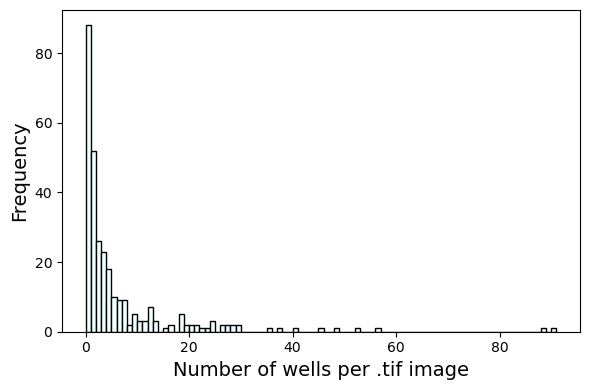

In [5]:
# Histogram of well counts per image
fig1 = plt.figure(1, figsize=(6,4), tight_layout=True)
plt.hist(counts_df['Well count'], histtype='bar', bins=91, facecolor='azure', edgecolor='k')
plt.xlabel('Number of wells per .tif image', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

Of our 294 .tif files, 88 images contain no labeled wells. From the remainder 206 .tif files, 26 images contain 911 labeled wells, i.e., over 50% of labels. Our target labels are evidently unevenly distributed across input images.

Let's visualize some representative images to develop an understanding of what an oil well looks like in an RGB satellite image. In the below raster plots, blue scatter points mark the coordinates of labeled oil wells.

<div style="display: flex; flex-wrap: wrap;">
    <div style="flex: 45%; padding: 5px;">
        <img src="https://github.com/akshaysuresh1/oil-well-detection/blob/main/misc_images/img_21524_14588_wells.png?raw=True" alt="img_21524_14588" width="600" />
        <p style="text-align: center;"><i>(a) 91 labeled wells observed in low spatial resolution.</i></p>
    </div>
    <div style="flex: 45%; padding: 5px;">
        <img src="https://github.com/akshaysuresh1/oil-well-detection/blob/main/misc_images/img_21311_11428_wells.png?raw=True" alt="img_21311_11428" width="600" />
        <p style="text-align: center;"><i>(b) 52 labeled wells seen in low spatial resolution</i></p>
    </div>
</div>

<div style="display: flex; flex-wrap: wrap;">
    <div style="flex: 45%; padding: 5px;">
        <img src="https://github.com/akshaysuresh1/oil-well-detection/blob/main/misc_images/img_20708_13514_wells.png?raw=True" alt="img_20708_13514" width="600" />
        <p style="text-align: center;"><i>(c) An ordered arrangement of 35 labeled wells</i></p>
    </div>
    <div style="flex: 45%; padding: 5px;">
        <img src="https://github.com/akshaysuresh1/oil-well-detection/blob/main/misc_images/img_18304_13573_wells.png?raw=True" alt="img_18304_13573" width="600" />
        <p style="text-align: center;"><i>(d) 12 wells viewed in high spatial resolution</i></p>
    </div>
</div>

<div style="display: flex; flex-wrap: wrap;">
    <div style="flex: 45%; padding: 5px;">
        <img src="https://github.com/akshaysuresh1/oil-well-detection/blob/main/misc_images/img_17096_13685_wells.png?raw=True" alt="img_17096_13685" width="600" />
        <p style="text-align: center;"><i>(e) 2 wells, each seen with dark spots close to their centroids and rectangular enclosing boundaries.</i></p>
    </div>
    <div style="flex: 45%; padding: 5px;">
        <img src="https://github.com/akshaysuresh1/oil-well-detection/blob/main/misc_images/img_21587_11313_wells.png?raw=True" alt="img_21587_11313" width="600" />
        <p style="text-align: center;"><i>(f) 6 wells surrounded by circular rims</i></p>
    </div>
</div>

As seen above, satellite images show a large diversity of background terrain. Further, the appearance of an oil well changes drastically based on the image's spatial resolution. Satellite images, when captured at higher [off-nadir angles](https://www.euspaceimaging.com/what-is-ona-off-nadir-angle-in-satellite-imagery/), can cover greater expanses of area albeit with poorer spatial resolution. 

All 294 .tif images in this study share a common pixel resolution of about 0.1545 arcseconds along both longitude and latitude. Panels (a) &ndash; (c) were likely taken by the satellite at larger off-nadir angles than in panels (d) &ndash; (f). Visual identification of oil wells from panels (a) &ndash; (c) solely is challenging without any prior knowledge of the defining characteristics of an oil well. Instead, what can one learn about oil wells from the comparatively high spatial resolution images such as those in panels (c) – (f)?

1. Most oil wells have a black spot located close to them in their satellite images.
2. Oil wells tend to be surrounded by well-defined rectangular or circular boundaries.
3. Oil wells have road connections.
4. Oil wells exhibit a variety of spatial orientations in images.
5. In most images, oil wells show no regular clustering pattern. The grid-like arrangement seen in panel (c) seems to be an outlier.

**Idea:** As a first pass, train a deep learning model to identify oil wells using the (comparatively) high spatial resolution images at hand. During model training, one can randomly blur images with an isotropic 2D Gaussian filter to mimic a low spatial resolution scenario. That way, the model learns to adapt to input images with diverse spatial resolution.

---

### 2. Model Selection <a name="model-selection"></a>

Traditional deep learning models have typically relied on large amounts of accurately annotated training data, which can be difficult and costly to obtain. As an alternative, [transfer learning](https://www.sciencedirect.com/topics/computer-science/transfer-learning) has emerged as a valuable technique in modern deep learning applications.

Transfer learning involves adapting a model trained on one dataset to another domain, often with minimal modifications (few-shot learning) or even without any adjustments (zero-shot learning). In the case of few-shot learning, the model's final layers are fine-tuned using a small amount of high-quality domain-specific labeled data.

Considering the limited availability of only 294 .tif images at the outset, few-shot transfer learning holds promise for effective oil well detection in this project.

#### 2.1 Chosen Approach: Few-shot Transfer Learning for Binary Semantic Segmentation Using U-Net <a name="chosen-model"></a>

[Semantic segmentation](https://www.ibm.com/topics/semantic-segmentation) is a computer vision technique that attempts to assign a class label to each and every pixel in an input image. In this study, pixels in an input image can have one of two class labels.

| Class label | Description|
|:-------------------------:|:-------------------------:|
|0| Pixel is not part of an oil well. |
|1| Pixel is part of an oil well. |

The U-Net model, pioneered by [Ronneberger, Fischer & Brox (2015)](https://arxiv.org/abs/1505.04597), is a popular architecture for semantic segmentation problems. First trained for biomedical image segmentation tasks, this model efficiently leverages small amounts of data while retaining speed and accuracy. The diagram below shows the U-Net architecture developed by [Buda, Saha & Mazurowski (2019)](https://doi.org/10.1016/j.compbiomed.2019.05.002) for abnormality segmentation in human brain MRI scans. The model's name draws inspiration from its bowl-shaped architecture diagram comprising of two components – an encoder network forming a contracting path and a decoder network constituting an expansive path. 

The contracting path is a typical feed-forward convolutional neural network involving max-pooling layers sandwiched between series of convolutional layers with ReLU activation functions. In the architecture below, batch normalization has been introduced after every convolutional layer to mitigate against exploding gradients during backpropagation. The contracting path learns the broad context of an image at multiple scales, progressively reducing the image spatial resolution.

The decoder network complements the contraction by identifying localized structures in images through a sequence of up-convolutions and concatenations of outputs from the encoder network. Finally, the output of the decoder network is normalized to a probability mask using a sigmoid function. 

<div>
<center><img src="https://github.com/akshaysuresh1/oil-well-detection/blob/main/misc_images/unet_model.png?raw=True" alt="U-Net model architecture" width="900" /></center>
<p><center><i>U-Net model architecture designed by <a href="https://doi.org/10.1016/j.compbiomed.2019.05.002">Buda, Saha & Mazurowski (2019)</a>. Figure generated by self using Microsoft Powerpoint.</i></center></p>
</div>

**References for the above model architecture and pretrained weights:** 
- <u>Article:</u>
  Mateusz Buda, Ashirbani Saha, Maciej A. Mazurowski,
  *Association of genomic subtypes of lower-grade gliomas with shape features automatically extracted by a deep learning algorithm*,
[Computers in Biology and Medicine, Volume 109, 2019, Pages 218-225, ISSN 0010-4825](https://doi.org/10.1016/j.compbiomed.2019.05.002).

- <u>Github repository of PyTorch model implementation:</u> [https://github.com/mateuszbuda/brain-segmentation-pytorch](https://github.com/mateuszbuda/brain-segmentation-pytorch)

**Strategy:** In this study, I load pretrained parameters from the U-Net model trained by [Buda, Saha & Mazurowski (2019)](https://doi.org/10.1016/j.compbiomed.2019.05.002) and then retrain the weights in the final few decoder layers. Layers with weights unfrozen for training are indicated by a pale yellow box in the above architecture diagram.

In [6]:
# Load U-Net model and verify model architecture.
N_input_channels = 3 # RGB
N_output_channels = 1 # Binary segementation mask
model = UNet(N_input_channels, N_output_channels)

In [7]:
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,216
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,432
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,864
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,

The above U-Net model, if to be trained from scratch, would have over 7.7 million trainable parameters.

In [8]:
# Load pretrained weights.
pretrained_state_dict = torch.load('unet_weights/unet_pretrained_weights.pt',map_location=torch.device('cpu'))
# Freeze all layers.
for param in model.parameters():
    param.requires_grad = False
# Unfreeze weights in final few layers.
for param in model.conv.parameters():
    param.requires_grad = True
for param in model.decoder1.parameters():
    param.requires_grad = True
for param in model.upconv1.parameters():
    param.requires_grad = True
for param in model.decoder2.parameters():
    param.requires_grad = True
for param in model.upconv2.parameters():
    param.requires_grad = True
# Compute the number of trainable parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
trainable_params = sum([np.prod(p.size()) for p in model_parameters])
print('No. of trainable model parameters for transfer learning = %d'% (trainable_params))

No. of trainable model parameters for transfer learning = 179713


Training about 180,000 parameters seems more reasonable with the limited data at hand.

Returning to the problem statement, the objective is to return the coordinates of all potential oil wells in the image. Here, I train a U-Net model via transfer learning to process the RGB satellite image. This model outputs binary segmentation masks. After obtaining the segmentation masks, I apply K-means clustering to locate the pixel coordinates of candidate oil well centroids. These centroids are then transformed into longitude and latitude coordinates using the georeferenced axes of the input .tif image.

<center><img src="https://github.com/akshaysuresh1/oil-well-detection/blob/main/misc_images/approach.png?raw=True" alt="Problem solving approach" width="800" /></center>

#### 2.2 Model Limitation and Alternate Approaches <a name="other-approaches"></a>

Semantic segmentation is inadequate at distinguishing between different instances of the same class. Thus, I employ K-means clustering to segregate pixels corresponding to individual oil wells. However, K-means clustering may inaccurately group together oil wells that share a boundary.

- Object detection models like the Single Shot Multibox Detector ([Liu et al., 2015](https://arxiv.org/abs/1512.02325)) can 
accurately locate and distinguish between multiple oil wells using rectangular bounding boxes, albeit with the loss of fine-grained information on the shape of each well.

- Instance segmentation combines the strengths of both semantic segmentation and object detection. It provides detailed, pixel-wise segmentation maps for each candidate oil well, effectively overcoming the challenge of differentiating between overlapping or adjacent oil wells while capturing their shapes with high granularity. However, this method entails higher computational costs compared to semantic segmentation or object detection models.

---

### 3. Data Preparation <a name="data-prep"></a>

**Data set for machine learning:** After visually reviewing all available data, I selected a subset of 203 images for machine learning (ML) purposes. For an image to be included in the ML set, at least 75% of labeled oil wells in the image had to exhibit two or more of the following characteristics.
- Presence of black spots nearby
- Visible road connections
- Clearly defined ridges demarcating their boundaries (often rectangular or circular).

I created masks for semantic segmentation by manually delineating the boundaries of oil wells using [Roboflow](https://roboflow.com/). 
I incorporated into the masks, visible road connections to oil wells wherever possible, to assist the ML model in recognizing oil wells as structures with road connections. Below is an example image from the ML set along with its corresponding mask.

<center><img src="https://github.com/akshaysuresh1/oil-well-detection/blob/main/misc_images/image_mask.png?raw=True" alt="Image with mask" width="800" /></center>
<center><p><i><b>Left:</b> An RGB satellite image. <b>Middle:</b> Binary mask manually created for semantic segmentation. <b>Right:</b> Binary mask superposed on background RGB satellite image to reveal regions marked as belonging to one or more oil wells.</i></p></center>

All ML-ready images and masks can be found in the `ml_data` folder.

#### 3.1 Train-validation split <a name="data-split"></a>

<div>
<center><img src="https://github.com/akshaysuresh1/oil-well-detection/blob/main/misc_images/hist_MLset.png?raw=True" alt="Histogram of labeled oil well counts per image" width="500" /></center>
<p><center><i>Histogram of labeled oil well counts in the 203 ML-ready images</i></center></p>
</div>
    
The histogram above illustrates the distribution of labeled oil well counts per image in the ML dataset. Notably, the majority of images do not contain any labeled oil wells, and even when present, these wells occupy only a small portion of the image. Consequently, there is a significant data imbalance across segmentation classes, both at the pixel and image levels.

In such scenarios, randomly partitioning the ML data into training and validation sets is not recommended. For example, in an 80-20 train-validation split, with nearly 43% of the 203 images containing no wells, a random partition could lead to a validation set exclusively comprised of images containing no labeled oil wells. This could result in a model achieving artificially high performance on the validation set by focusing solely on background pixels and ignoring foreground pixels representing oil wells. 

Let `bool_wells` denote a Boolean flag indicating whether an image contains at least one labeled oil well. One could potentially partition the ML dataset on `bool_wells` and execute random train-validation splits separately on each such partition. However, this approach also carries a risk. Consider a data split of ``bool_wells = True``, where the small number of images with larger well counts get included in the validation set alone. Note that images with larger well counts tend to have poorer spatial resolution, leading to fewer foreground pixels per oil well in comparison to the high spatial resolution images. Upon training with the high spatial resolution images exclusively, a model may then not generalize well to the low spatial resolution counterparts in the validation set.

To address data imbalance at the image level, I therefore propose the following scheme.

1. Define $M$ as the maximum number of labeled oil wells in a single image from the ML set and assume a fractional validation set size of $x$.
2. Build a histogram of oil well counts per image, with one bin per integer well count in the range $[0, M]$.
3. For bins with frequencies greater than or equal to $1/x$, implement a stratified train-validation split based on integer well counts.
4. Group the remaining images and randomly distribute them between the training set and validation set in the ratio $(1−x):x$.

The histogram at the top of this section demonstrates the aforementioned data splitting scheme for $x=0.2$, resulting in a training set of 161 images and a validation set of 42 images. Furthermore, the below figure highlights the success of the scheme in achieving remarkably similar well count distributions across images in the training and validation sets.

In [9]:
mlset_df = pd.read_csv('eda/curated_set.csv')
img_train, img_val = custom_train_val_split('eda/curated_set.csv', val_size=0.2)
# Names of images in the training and validation  set
img_train = set(img_train)
img_val = set(img_val)
# Well counts in training and validation set images
wellcount_train = []
wellcount_val = []
for i, record in mlset_df.iterrows():
    if record['Image'] in img_train:
        wellcount_train.append(record['Well count'])
    else:
        wellcount_val.append(record['Well count'])
# Bin well counts separately for training and validation data.
M = mlset_df['Well count'].max()
bins = np.arange(M+2)-0.5 # 1 bin per integer well count in the range [0, M]
pdf_train, _ = np.histogram(wellcount_train, bins=bins, density=True)
pdf_val, _ = np.histogram(wellcount_val, bins=bins, density=True)

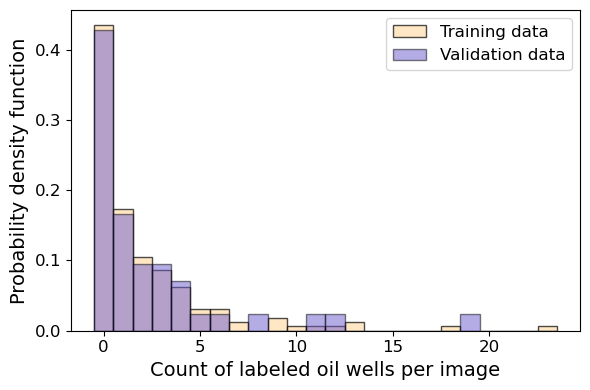

In [10]:
fig2 = plt.figure(num=2, figsize=(6,4), tight_layout=True)
plt.hist(wellcount_train, bins=bins, density=True, facecolor='navajowhite', edgecolor='k', alpha=0.7, label='Training data')
plt.hist(wellcount_val, bins=bins, density=True, facecolor='slateblue', edgecolor='k', alpha=0.5, label='Validation data')
plt.xlabel('Count of labeled oil wells per image', fontsize=14)
plt.ylabel('Probability density function', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

One can statistically quantify the similarity between the two probability density functions (PDFs) in the above figure using the [Kolmogorov-Smirnov test](https://arize.com/blog-course/kolmogorov-smirnov-test/). <br>
**Null hypothesis, $H_0$:** Histograms of well counts for the training and validation datasets share the same underlying distribution. <br>
**Alternate hypothesis, $H_1$:** Histograms of well counts for the training and validation datasets come from different distributions. <br>

Setting a confidence level of 95%, I will reject $H_0$ in favor of $H_1$ if the p-value is less than 0.05.

In [11]:
# Compute 2-sample KS test.
ks_2samp(pdf_train, pdf_val)

KstestResult(statistic=0.16666666666666666, pvalue=0.9024001944012529, statistic_location=0.018633540372670808, statistic_sign=1)

The p-value obtained is signficantly higher than 0.05, thereby favoring the null hypothesis $H_0$.

#### 3.2 Data Scaling and Augmentation <a name="data-aug"></a>

Neural networks often benefit from having their inputs scaled to the range [0, 1] or [-1, 1]. Activation functions such as the ReLU and the sigmoid function can best capture non-linearities when their inputs are close to zero. Furthermore, such scaling can prevent weights from getting biased by features with larger absolute magnitudes, facilitating faster convergence to the optimal model parameters. **In preparation for model training, I linearly scaled integer RGB image data from their respective min-max values to [0, 1], ensuring the outputs are cast as floats.**

Data augmentation is essential for enhancing model performance by amplifying the quantity of training data and lowering the risk of positional biases. By artificially diversifying the training dataset through operations such as flipping, rotation, cropping, and Gaussian blurring, data augmentation can enable a model to learn robust patterns and generalize better to unseen data. In this study, I implemented data augmentation through the following actions specified in the file `scripts/data_utils.py`.

1. Flip 50% of training images horizontally at every epoch. 
2. Flip 50% of training images vertically at every epoch. 
3. Blur 50% of training images via convolution with an isotropic 2D Gaussian filter of standard deviation $s$ pixels, where $s$ is a floating-point value randomly sampled from a uniform distribution over (0, 1]. 

---

### 4. Model Training <a name="model-training"></a>

Command line call from base directory: `python scripts/train.py -i config/train.cfg`

I trained my U-Net model for 2000 epochs using batch gradient descent with a batch size of 32 and an initial learning rate of $10^{-5}$. Throughout training, I employed the Adam optimizer to dynamically adjust the learning rate, with the goal of minimizing the Dice loss. The training process was completed in 12 hours using an NVIDIA A40 GPU.

#### 4.1 Chosen Loss Function: Dice Loss <a name="loss-function"></a>

The training and validation datasets now share the same distribution of oil well counts per image. However, within each image, the background class (label 0) dominates the foreground class (label 1) in pixel count. To address this pixel-level imbalance, it is crucial to choose a loss criterion that performs equally well on images with different counts of labeled oil wells. This is where the Dice loss becomes invaluable. 

Given pixel-level maps of ground truth class labels $Y$ and predicted labels $P$ , the Dice loss of an image is defined as follows.
\begin{align}
{\rm Dice \ loss \ } &= 1 - \frac{2 |Y \cap P| +1}{|Y| + |P| + 1} \\
&= 1 - \frac{2 \times {\rm True \ Positives} + 1}{2 \times {\rm True \ Positives} + {\rm False \ Positives} + {\rm False \ Negatives} + 1}.
\end{align}
Here, $|.|$ indicates the operation of summing over pixel values in a map. Note that for a perfect segmentation, $Y=P$ and the Dice loss is 0. Meanwhile, for a null segmentation, $P=0$ and the Dice loss approaches 1 with increasing number of foreground pixels in $Y$.  Minimizing the Dice loss thus entails high performance on training images with different counts of labeled oil wells. 

Another loss function that addresses pixel-level class imbalance similarly is the Jaccard loss, defined as:
\begin{align}
{\rm Jaccard \ loss \ } &= 1 - \frac{|Y\cap P| +1 }{|Y \cup P| + 1} \\
&= 1 -  \frac{{\rm True \ Positives} + 1}{{\rm True \ Positives} + {\rm False \ Positives}  + {\rm False \ Negatives} + 1}.
\end{align}
Like the Dice loss, the Jaccard loss also equals 0 for perfect segmentation.

Weighted distribution-based losses such as the balanced cross-entropy and the focal loss are also viable alternatives, however requiring tuning of their respective hyperparameters for optimal results.

#### 4.2 Loss curve <a name="loss-curve"></a>

In [12]:
# Load loss curve data.
results_df = pd.read_csv('results_epoch2000/model_loss.csv')

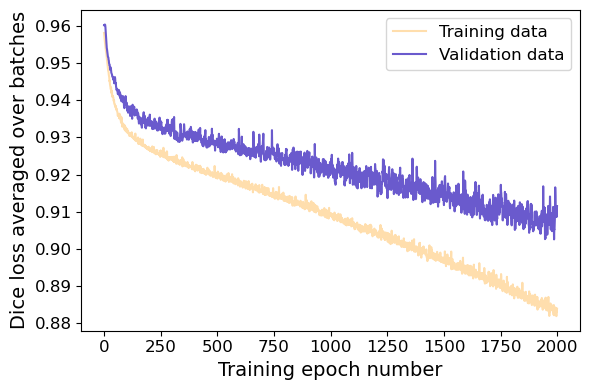

In [13]:
# Plot loss curve data.
fig3 = plt.figure(num=3, figsize=(6,4), tight_layout=True)
plt.plot(results_df['train_loss'], color='navajowhite', linestyle='-', label='Training data')
plt.plot(results_df['val_loss'], color='slateblue', linestyle='-', label='Validation data')
plt.xlabel('Training epoch number', fontsize=14)
plt.ylabel('Dice loss averaged over batches', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Initially, the training and validation losses start off at similar values. However, over time, the training loss decays more rapidly than the validation loss, suggesting that the model has begun to overfit the training data.

Strategies to counter overfitting include gathering more training data, reducing the number of trainable parameters. and introducing regularization techniques such as dropout during model trainining.

--- 

### 5. Future Work and Additional Insights <a name="future-work"></a> 

In this study, the satellite images analyzed encompass a diverse array of landscapes, featuring oil wells scattered across various terrains. Recognizing the necessity of training a model adept at accurately detecting oil wells amidst diverse backgrounds, the integration of data augmentation through generative adversarial networks (GANs: [Goodfellow et al., 2014](https://arxiv.org/abs/1406.2661)) emerges as a promising avenue for exploration. By leveraging a subset of super-resolved oil wells extracted from different terrains at a fixed spatial resolution as input for a GAN, a high-quality synthetic dataset can be generated. This synthetic dataset, enriched with diverse backgrounds, can serve as a valuable asset for augmenting the training data. Not only does it bolster the volume of the training dataset, but it also introduces crucial statistical terrain variability, thereby mitigating the risk of overfitting during model training.

**Questions for future thought:**
1. What additional data augmentation algorithms can I apply to the satellite data at hand? Are there specific data augmentation routines that must be avoided?
2. How does one teach a computer vision model to adapt successfully to images of different spatial resolution?

--- 